## Dimension reduction techniques for cell-phone customer churn classification
In this notebook, I will explore truncated SVD and PCA as a preprocessing dimension reduction step in training a random forest classifier. Though these techniques are touted as being very similar, we will explore if there are any concrete differences in their perfomrance on classifying churn based on the reduced set of cell-phone customer features that they create.

Dataset sources for this notebook:

https://bml-data.s3.amazonaws.com/churn-bigml-80.csv

https://bml-data.s3.amazonaws.com/churn-bigml-20.csv

To use: Replace filepaths in the second code box with your own filepath

**Author: John Saja**

## Import dependencies

In [7]:
import os
import sys

spark_path = "C:\spark\spark-2.1.0-bin-hadoop2.7"

os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

import pyspark
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext

# Stop Spark context started by default and start another Spark context
# Allows code to reexecute without error
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

import pyspark.sql
from pyspark.sql.functions import col, avg
import numpy as np
import pandas as pd

# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.mpl_style = 'default'

import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import UserDefinedFunction
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from sklearn import tree
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
import pickle

In [8]:
CV_data = sqlContext.read.load('Desktop/INET 4710/labs/lab8/churn80.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

final_test_data = sqlContext.read.load('Desktop/INET 4710/labs/lab8/churn20.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

CV_data_pd = pd.read_csv('Desktop/INET 4710/labs/lab8/churn80.csv')

final_test_data_pd = pd.read_csv('Desktop/INET 4710/labs/lab8/churn20.csv')

CV_data.cache()
CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



## Profiling our dataset

In [9]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns).transpose()

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account length,128,107,137,84,75
Area code,415,415,415,408,415
International plan,No,No,No,Yes,Yes
Voice mail plan,Yes,Yes,No,No,No
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total day charge,45.07,27.47,41.38,50.9,28.34
Total eve minutes,197.4,195.5,121.2,61.9,148.3


## Building the Correlation Matrix
This is based on a sample of 10% of the data. Additionally, this is used to visually see any abnormalities in the data. In the next section, we can see what dimensions can be immediately thrown out, even before doing 'real' dimension reduction techniques. 

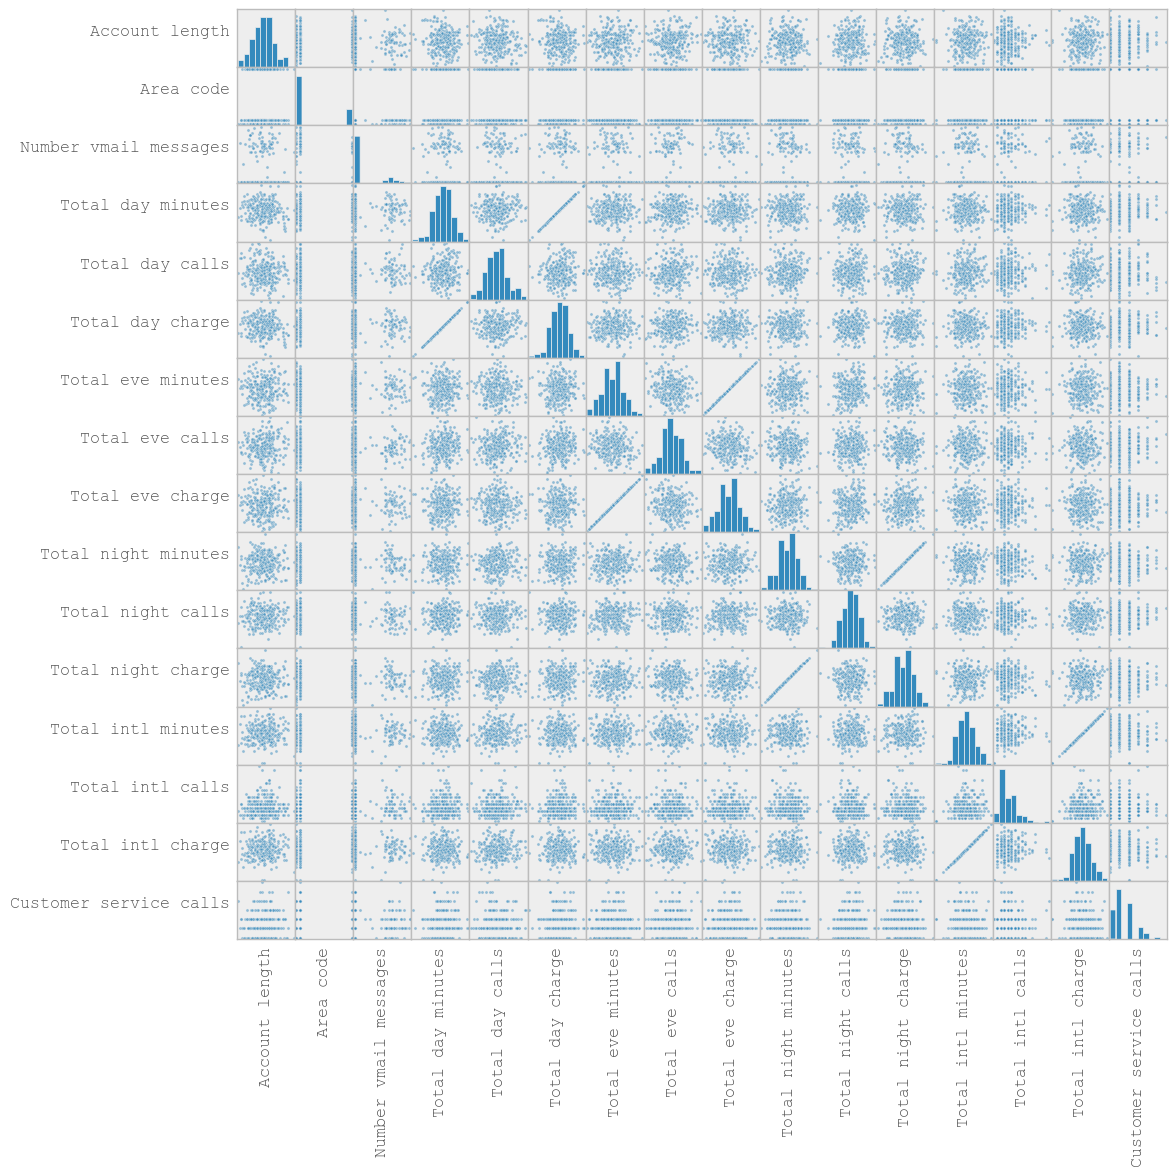

In [10]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()

axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## Now we transform dataset, and drop a few carefully preselected columns before applying Dimension Reduction techniques
We want to drop the State column because it cannot be mapped into a numeric data type easily.
Additionally, Area Code will be dropped because it will inevitably skew any model results due to the nature of how they are
numbered. Additionally, it would be a smart move to manually remove any dimensions which introduce collinearity, rather than having the dimension reduction techniques do so. Here, we also map categorical string data to numeric data, as you can see from the first line of the next box.

In [11]:
binary_map = {'Yes':1.0, 'No':0.0, True:1.0, False:0.0}

toNum = UserDefinedFunction(lambda k: binary_map[k], DoubleType())

CV_data = CV_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('Churn', toNum(CV_data['Churn'])) \
    .withColumn('International plan', toNum(CV_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(CV_data['Voice mail plan'])).cache()

final_test_data = final_test_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('Churn', toNum(final_test_data['Churn'])) \
    .withColumn('International plan', toNum(final_test_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(final_test_data['Voice mail plan'])).cache()

CV_data_pd = CV_data.toPandas()
final_test_data_pd = final_test_data.toPandas()

In [12]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns).transpose()

,0,1,2,3,4
Account length,128.0,107.0,137.0,84.0,75.0
International plan,0.0,0.0,0.0,1.0,1.0
Voice mail plan,1.0,1.0,0.0,0.0,0.0
Number vmail messages,25.0,26.0,0.0,0.0,0.0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110.0,123.0,114.0,71.0,113.0
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99.0,103.0,110.0,88.0,122.0
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91.0,103.0,104.0,89.0,121.0


## Create a Stratified Sample
This reduces bias that the model might introduce by making roughly equal amounts of observations for each churn sample.

In [13]:
stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()

stratified_CV_data_pd = stratified_CV_data.toPandas()

## Before, we had this many observations for each churn label

In [14]:
CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,2278
1,1.0,388


## Now, we have roughly equal amounts

In [15]:
stratified_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,416
1,1.0,388


## Create Train/Test set and label classification lists (pandas data, pyspark data respectively)
Labels will need to be created for both train/test sets because they may result in different splits.

In [16]:
#First, make the train/test 80%/20% split (Pandas)
train = stratified_CV_data_pd.sample(frac=0.8, random_state=42)
test = stratified_CV_data_pd.drop(train.index)

#next, do so for pyspark datafromes (PySpark)
ps_train, ps_test = stratified_CV_data.randomSplit([0.8, 0.2])

#Create the set of labels (Pandas)
targetLabels_train = train['Churn'].tolist()
targetLabels_test = test['Churn'].tolist()
targetLabels_final_test = final_test_data_pd['Churn'].tolist()

#Create set of labes (Pyspark)
targetLabels_ps_train = ps_train.select('Churn').toPandas()
targetLabels_ps_train = targetLabels_ps_train['Churn'].tolist()
targetLabels_ps_test = ps_test.select('Churn').toPandas()
targetLabels_ps_test = targetLabels_ps_test['Churn'].tolist()

## Dimension Reduction Technique #1 - Truncated SVD (sklearn)
## Followed by Classification via Random Forest Classifier (sklearn)
Truncated SVD is another name for low-rank approximation of a matrix. Essentially, this is just SVD but with X number of singular components set to 0. Essentially, whatever we pass in to th n_components parameter of the model will be the resulting dimensionality of our data. To this end, this is similar to SVD, but can be thought of as implenting dimension reduction in one pass of the algorithm. One difference between this and PCA is that it does not center the data before the model is created, which may be one source of obtaining different results between the two techniques.

Truncated SVD Scalability - This algorithm can be implemented as an iterative online algorithm through the genism package, so you won't need to fit the entire training or test set into main memory (RAM). Rather, it will compute partial computations for each portion of the data. The extra feature of this specific method of scaling is that new observations can be added at any time.

Source: https://radimrehurek.com/gensim/models/lsimodel.html

Also, Random Forest was chosen to be the classifier due to the fact that it decreases the model's variance during training (compared to classic decision trees, which tend to overfit). Additionally, considering we will be working with 1-14 possible components, we may incur a high chance of overfitting if the optimal number of components is determined to be high.

In [26]:
# empty list that will hold cv scores, number of components for SVD
cv_scores = []
numComponents = []
train_error = []
test_error = []

#Used to keep track of model that produces the highest cross-validated classification accuracy
bestClassRate = 0

#Create a truncated SVD model for each n, where n is the # of components 1 =< n =< 14
for x in range(1,14):
    #First, create Truncated SVD model with x components
    model = TruncatedSVD(n_components = x)
    
    #Transform train/test sets based on that model
    train_transformed = model.fit_transform(train)
    test_transformed = model.transform(test)
    
    #next, instantiate Random Forest Classifier and train it on our transformed data
    clf = RandomForestClassifier()
    clf = clf.fit(train_transformed, targetLabels_train)
    
    #Perform k-fold cross validation on the current model
    scores = cross_val_score(clf, test_transformed, targetLabels_test, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    numComponents.append(x)
    
    #Get train/test error
    train_error.append(1 - clf.score(train_transformed, targetLabels_train))
    test_error.append(1 - clf.score(test_transformed, targetLabels_test))
    
    #Now, pickle all pertinent model information if the model currently has the highest accuracy score
    if cv_scores[x-1] > bestClassRate:
        bestModel = pickle.dumps(clf)
        bestSVD = pickle.dumps(model)
        bestTransform = pickle.dumps(train_transformed)
        bestClassRate = cv_scores[x-1]
        bestX = x

## Next, profile the transformed training dataset produced by our best model
The columns are the principal components

In [27]:
newCol = []
row_list = []

# Build new column names relating to each component
for x in range(1,bestX+1):
    newCol.append(x)

#Load the pickled data
profileData = pickle.loads(bestTransform)
num_rows, num_cols = profileData.shape

#create indexes for customer#
for i in range(1,num_rows+1):
    exec("row_list.append('customer%d')" % i)

pd.DataFrame(data = profileData, index=row_list, columns=newCol).head(20)

,1,2,3,4,5,6,7,8,9,10,11,12
customer1,428.502670,26.486663,15.027781,-14.909952,11.801274,19.144765,-1.654897,-18.051835,-1.695174,3.354551,2.382000,0.715321
customer2,393.208706,31.164518,-31.653762,75.230419,-40.350629,7.693486,-4.811718,-4.724082,-0.826240,0.352688,-0.020305,-0.232484
customer3,381.986489,4.181310,-5.987895,44.484249,-33.712336,12.323356,-26.091256,-17.285555,-0.665718,-0.623687,-0.590011,-0.660255
customer4,421.710436,-2.842460,-77.714606,19.224242,-23.125690,-4.101284,-29.851807,-12.246212,1.216803,0.903771,0.118636,0.124316
customer5,398.951392,73.821673,76.497379,27.836708,-27.295789,-17.255226,23.614894,-10.239949,-0.797146,-0.202641,0.097988,0.003014
customer6,423.245011,47.646017,-53.801008,-5.585166,8.805062,17.298227,14.848867,7.783183,-0.565306,0.114936,0.019458,0.104758
customer7,396.470545,88.747068,4.058876,28.280382,-5.907027,-0.066415,-12.958162,-20.793837,-0.548557,1.192059,-0.012293,0.256901
customer8,352.906092,119.387628,112.398667,25.702757,10.322049,-14.812229,-0.200818,-2.234034,3.567249,1.651201,-1.594876,0.402732
customer9,366.316815,62.106196,-31.071211,-0.516501,0.250627,14.365944,-25.966302,4.518009,0.351225,0.782234,0.366068,1.232460
customer10,412.539113,8.833838,4.349477,31.344636,-13.133446,9.031598,-15.274760,-20.794075,4.211520,2.498838,1.017478,-0.379300


## Finally, plot all the results from our best model

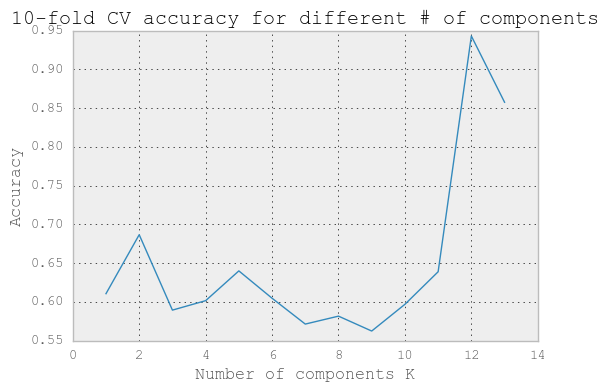


Optimal components: 12 with an accuracy of: 94.32%
The final test on the final_test_data dataset had an accuracy of:  96.72%
This means the model with 12 components is able to generalize within  2.40%  of the model's cross-validated accuracy


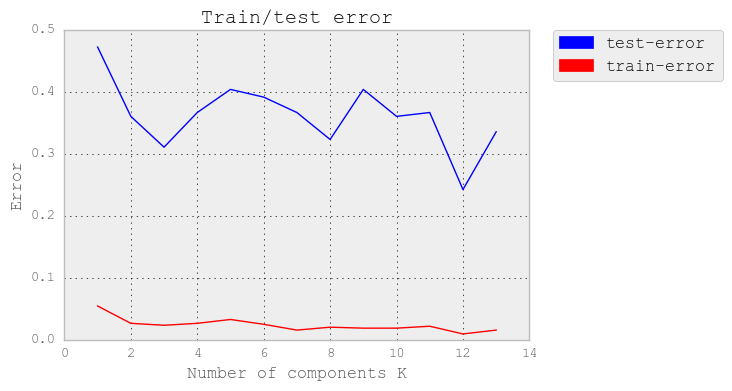

In [28]:
plt.plot(numComponents, cv_scores)    
plt.xlabel('Number of components K')
plt.ylabel('Accuracy')
plt.title('10-fold CV accuracy for different # of components')
plt.show()

max = 0
index = 0
for item in cv_scores:
    if cv_scores[index] > max:
        max = cv_scores[index]
        cv_index = index+1
    index = index + 1

print("\nOptimal components:", cv_index, "with an accuracy of:", "{:.2%}".format(max))


#use our best model to classify final_test_data to test how well the model generalizes
finalScore = []
clfBest = pickle.loads(bestModel)
svdBest = pickle.loads(bestSVD)
best = pickle.loads(bestTransform)

#transform final_test_data according to the SVD model
final = svdBest.transform(final_test_data_pd)

scores = cross_val_score(clfBest, final, targetLabels_final_test, cv=10, scoring='accuracy')
finalScore.append(scores.mean())

print("The final test on the final_test_data dataset had an accuracy of: ", "{:.2%}".format(finalScore[0]))
print("This means the model with %d components is able to generalize within " % cv_index, "{:.2%}".format(finalScore[0]-max), " of the model's cross-validated accuracy")

#Train/test error graph
plt.plot(numComponents, train_error, 'r', numComponents, test_error, 'b')
plt.xlabel('Number of components K')
plt.ylabel('Error')
plt.title('Train/test error')
red_patch = mpatches.Patch(color='r', label='train-error')
blue_patch = mpatches.Patch(color='b', label='test-error')
plt.legend(handles=[blue_patch,red_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Dimension Reduction Technique #2 - PCA (pyspark)
## Followed by Classification via Random Forest Classifier (sklearn)

PCA Scalability - PCA by itself suffers from the issue that all data must be processed in main memory (RAM). However, for sufficiently large datasets, you will end up using all available main memory, and thus crash. To remedy this, PCA can scale to large datasets by using a method called, "incremental PCA," which uses partial computations done to iterative chunks of the full dataset. This method produces nearly identical results to regular PCA, and is available through the sklearn library.

Source: http://scikit-learn.org/stable/modules/decomposition.html#decompositions

Lastly, this implementation has *horrific* runtime O(2N^2) due to the conversion of Pyspark DenseVectors to Numpy Arrays.

In [29]:
cv_scores2 = []
numComponents2 = []
train_error2 = []
test_error2 = []

#Used to keep track of model that produces the highest cross-validated classification accuracy
bestClassRate2 = 0

assembler_tr = VectorAssembler(inputCols=ps_train.columns, outputCol="features")
assembler_te = VectorAssembler(inputCols=ps_test.columns, outputCol="features")
assembler_final = VectorAssembler(inputCols=final_test_data.columns, outputCol="features")

output_tr = assembler_tr.transform(ps_train)
output_te = assembler_te.transform(ps_test)
output_final = assembler_final.transform(final_test_data)

#next, normalize data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel_tr = scaler.fit(output_tr)
scalerModel_te = scaler.fit(output_te)
scalerModel_final = scaler.fit(output_final)

# Normalize each feature to have unit standard deviation.
scaledData_tr = scalerModel_tr.transform(output_tr)
scaledData_te = scalerModel_te.transform(output_te)
scaledData_final = scalerModel_final.transform(output_final)

#Next, try PCA with n components where 1 =< n =< 14
for x in range(1,14):
    pca = PCA(k=x, inputCol="features", outputCol="pca").fit(scaledData_tr)

    #Get transformed data
    transformed_tr = pca.transform(scaledData_tr).select("pca").toPandas()
    transformed_te = pca.transform(scaledData_te).select("pca").toPandas()

    #put transformed data into correct format
    pca_train_transform = []
    pca_test_transform = []

    for observation in transformed_tr['pca']:
        pca_train_transform.append(observation.toArray())
    
    for observation in transformed_te['pca']:
        pca_test_transform.append(observation.toArray())
    
    #next, instantiate Random Forest Classifier and train it on our transformed data
    clf_pca = RandomForestClassifier()
    clf_pca = clf_pca.fit(pca_train_transform, targetLabels_ps_train)
    
    #Perform k-fold cross validation on the current model
    scores = cross_val_score(clf_pca, pca_test_transform, targetLabels_ps_test, cv=10, scoring='accuracy')
    cv_scores2.append(scores.mean())
    numComponents2.append(x)
    
    #Get train/test error
    train_error2.append(1 - clf_pca.score(pca_train_transform, targetLabels_ps_train))
    test_error2.append(1 - clf_pca.score(pca_test_transform, targetLabels_ps_test))
    
    #Now, pickle all pertinent model information if the model currently has the highest accuracy score
    if cv_scores2[x-1] > bestClassRate2:
        bestModel2 = pickle.dumps(clf_pca)
        bestTransform2 = pickle.dumps(pca_train_transform)
        bestClassRate2 = cv_scores2[x-1]
        bestX2 = x

## Next, profile the transformed training dataset produced by our best model
The columns are the principal components

In [30]:
newCol2 = []
row_list2 = []

# Build new column names relating to each component
for x in range(1,bestX2+1):
    newCol2.append(x)

#Load the pickled data
profileData2 = pickle.loads(bestTransform2)

#create indexes for customer#
for i in range(1,len(profileData2)+1):
    exec("row_list2.append('customer%d')" % i)

pd.DataFrame(data = profileData2, index=row_list2, columns=newCol2).head(20)

,1,2,3,4,5,6,7,8,9,10,11,12,13
customer1,228.450644,-15.282362,154.203445,21.047082,47.484692,-85.555942,127.844682,-10.123059,-8.725452,0.820100,-6.590729,-0.323335,-0.276391
customer2,183.675184,-26.645060,200.016238,23.180651,65.413704,-8.862319,134.650046,-6.656842,-7.852737,2.035185,-3.442374,0.395487,-0.750830
customer3,252.993174,28.325896,205.519282,24.870992,60.134415,-98.251004,150.789141,-11.007034,-12.517020,1.690952,-4.754729,-1.255339,-0.678103
customer4,246.083238,93.952254,296.676177,27.400644,39.864555,-60.060410,125.652040,-8.841619,-8.315839,-0.641347,-1.985790,-0.342431,-1.320514
customer5,265.109672,-14.852266,225.660622,28.773341,-34.348790,-35.294082,120.059406,-10.096729,-12.659455,0.918691,-4.863781,-1.252754,-0.649852
customer6,256.710540,16.540060,239.145631,34.734010,21.431981,-68.384755,120.023310,-10.186194,-8.452816,-2.576882,-4.020154,-0.955335,-0.638696
customer7,361.162564,-53.121484,203.900801,41.907670,19.065216,-90.384672,138.426383,-14.050333,-10.345496,1.167345,-2.408167,-0.278249,-0.062339
customer8,221.141799,-11.299888,243.745846,42.743115,2.683150,-54.558589,147.419871,-40.986355,-8.581174,3.148464,-7.576527,-0.366785,-0.294460
customer9,252.747797,-40.597343,352.890381,56.597766,27.045526,-74.677032,146.779188,-11.795451,-13.128568,1.378355,-2.081853,0.324894,-0.804484
customer10,271.684598,41.961744,264.510372,41.416075,10.024246,-28.309646,161.961021,-9.701888,-14.071760,-2.564156,-4.301936,-1.291446,-0.582097


## Finally, plot all the results from our best model

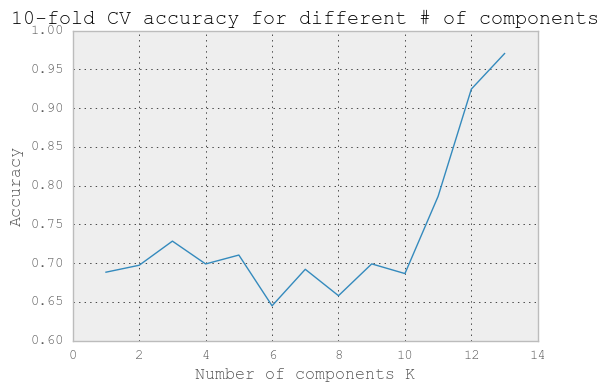


Optimal components:  13 , with an accuracy of =  97.05%
The final test on the final_test_data dataset:  98.36%
This means the model with 13 components is able to generalize within  1.30%  of the model's cross-validated accuracy


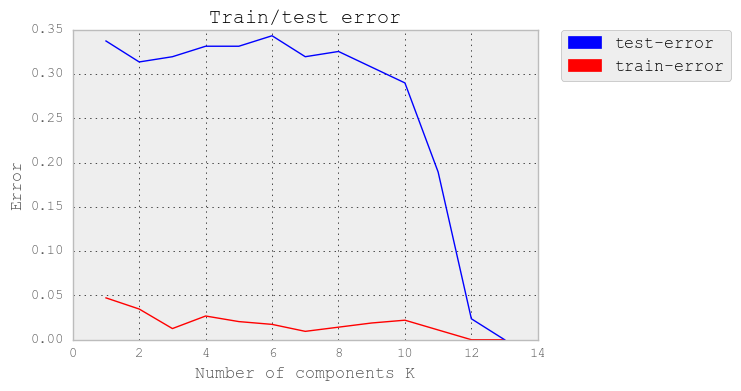

In [31]:
plt.plot(numComponents, cv_scores2)    
plt.xlabel('Number of components K')
plt.ylabel('Accuracy')
plt.title('10-fold CV accuracy for different # of components')
plt.show()

max2 = 0
index2 = 0
for item in cv_scores2:
    if cv_scores2[index2] > max2:
        max2 = cv_scores2[index2]
        cv_index2 = index2 +1
    index2 = index2 + 1
print("\nOptimal components: ", cv_index2, ", with an accuracy of = ", "{:.2%}".format(max2))

#use our best model to classify final_test_data to test how well the model generalizes
finalScore2 = []
clfBest2 = pickle.loads(bestModel2)
best2 = pickle.loads(bestTransform2)

#Grab the final scaled data
scaledData_final

#Perform PCA with the optimal # of components
pca = PCA(k=bestX2, inputCol="features", outputCol="pca").fit(scaledData_tr)

#Get transformed data
transformed_final = pca.transform(scaledData_final).select("pca").toPandas()

#Put transformed data into correct format 
pca_final_transform = []

for observation in transformed_final['pca']:
    pca_final_transform.append(observation.toArray())

scores = cross_val_score(clfBest2, pca_final_transform, targetLabels_final_test, cv=10, scoring='accuracy')
finalScore2.append(scores.mean())

print("The final test on the final_test_data dataset: ", "{:.2%}".format(finalScore2[0]))
print("This means the model with %d components is able to generalize within " % cv_index2, "{:.2%}".format(finalScore2[0]-max2), " of the model's cross-validated accuracy")

#Train/test error graph
plt.plot(numComponents2, train_error2, 'r', numComponents2, test_error2, 'b')
plt.xlabel('Number of components K')
plt.ylabel('Error')
plt.title('Train/test error')
red_patch = mpatches.Patch(color='r', label='train-error')
blue_patch = mpatches.Patch(color='b', label='test-error')
plt.legend(handles=[blue_patch,red_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


## A Quick Discussion of the differences between truncated SVD and PCA

Though results may vary for each run through the notebook, we can see that the PCA clearly always performs objectively better dimension reduction than the truncated SVD algorithm. Though this would be a pain to formally test, if you go through the notebook again you will very likely see results that are between 10-15% accuracy between the two methods. Also, the PCA/Random Forest classifier combination usually results in 99% accuracy on the final test dataset. This would suggest that SVD and PCA do have minor differences between how they work. Additionally, we noted earlier that the truncated SVD method does not center the dataset before creating the model, which may lead to the results being different.

However, this increased accuracy does not come without tradeoffs. While superior, this specific implementation of PCA has a runtime of O(2N^2), compared to the O(N) runtime of the truncated SVD. However, the PCA runtime can be improved with either a more efficient conversion of DenseVectors to Numpy arrays, or figuring out how to use the resulting transformed PCA data in a pyspark Random Forest Classifier (however, we cannot directly compare the performance between the two algorithms if this is done).

## Lastly, stop the SparkContext

In [6]:
sc.stop()